# Import block

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import scienceplots
import itertools

In [3]:
plt.style.use(['science', 'notebook', 'grid'])

# Function block

In [4]:
def load_df(col, n):
    schema = {
        'id': np.int32,
        'store_nbr': np.int16,
        'item_nbr': np.int32,
        'unit_sales': np.float32
    }
    chunks = pd.read_csv(
        'data\\part_1\\train.csv', 
        dtype=schema, 
        chunksize=1_000_000, 
        index_col='id',
        low_memory=False,
        parse_dates=['date']
    )
    return pd.concat((chunk.query(f"{col} == {n}") for chunk in chunks))


def fuller_test(df):
    test = adfuller(df)
    print('ADF Statistic: ', test[0])
    print('p-value: ', test[1])
    print('Critical Values:')
    for key, value in test[4].items():
        print(f'\t{key}: {value}')
    
    if test[0] < test[4]['5%']:
        print('Reject Ho - Time Series is Stationary')
    else:
        print('Failed to Reject Ho - Time Series is Non-Stationary')
        

def moving_average_forecast(df, window_size):
    forecast = []
    for time in range(len(df) - (window_size)):
        forecast.append(df[time: time + window_size].mean())
    return forecast


def plot_dataframe(df, lcut, cols, labels, xlabel, ylabel, colors=None):
    ax = df.iloc[lcut:].plot(
        figsize=(15, 7),
        y=cols,
        color=colors,
        lw=0.7
    )
    plt.legend(labels=labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    

def plot_model(df, df_pred, window_size):
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(data=df[-window_size * 3:], legend=False)
    sns.lineplot(data=df_pred[-window_size:], palette=['red'], legend=False)
    ax.tick_params(axis='x', rotation=45)
    plt.legend(labels=['Original signal', 'Predicted'])
    plt.show()
    
    
def print_metrics(df, df_pred, window_size):
    print(f'MSE is: {mean_squared_error(df[-window_size:], df_pred[-window_size:])}')
    print(f'MAE is: {mean_absolute_error(df[-window_size:], df_pred[-window_size:])}')
    print(f'MAPE is: {mean_absolute_percentage_error(df[-window_size:], df_pred[-window_size:])}')

# Характеристики и параметры временных рядов. Практика.

## Задание 1. Загрузите датасет train.csv. Датасет состоит из данных для различных магазинов (store_nbr). Для каждого магазина для дат указан продукт и его количество (unit_sales).

In [1]:
# Loading CSV file using function (big file, reading with chunks)
# df_25 = load_df('store_nbr', 25)

In [11]:
# df_25.to_parquet('data\\part_1\\store_25_only.parquet')
df_25 = pd.read_parquet('data\\part_1\\store_25_only.parquet')

In [12]:
df_25.sample(5)

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
37719868,2014-12-19,25,1464093,6.0,False
107808482,2017-03-01,25,1576323,2.0,False
53670123,2015-08-11,25,308726,12.0,False
2310369,2013-02-27,25,957098,3.0,None
14110159,2013-11-17,25,414478,6.0,None


In [9]:
df_25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057020 entries, 0 to 125440186
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int16         
 2   item_nbr     int32         
 3   unit_sales   float32       
 4   onpromotion  object        
dtypes: datetime64[ns](1), float32(1), int16(1), int32(1), object(1)
memory usage: 66.7+ MB


## Задание 2. Задание выполняется для магазина с номером 25. Для этого сгруппируйте данные по дате и суммируйте количество всех продаж.

In [13]:
df_25 = df_25.groupby('date')['unit_sales'].sum().reset_index()
df_25 = df_25.set_index(pd.DatetimeIndex(df_25['date']))
df_25.drop('date', axis=1, inplace=True)
df_25.rename({'unit_sales': 'original'}, axis=1, inplace=True)

### Let's check number of values of time series

In [11]:
df_25.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1618 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   original  1618 non-null   float64
dtypes: float64(1)
memory usage: 25.3 KB


**Total 1618 non-null values**

In [48]:
df_25.sample(5)

,original
date,
2013-02-26,18475.0
2015-12-31,49625.0
2013-03-22,24600.0
2017-05-13,41450.0
2016-11-14,38175.0


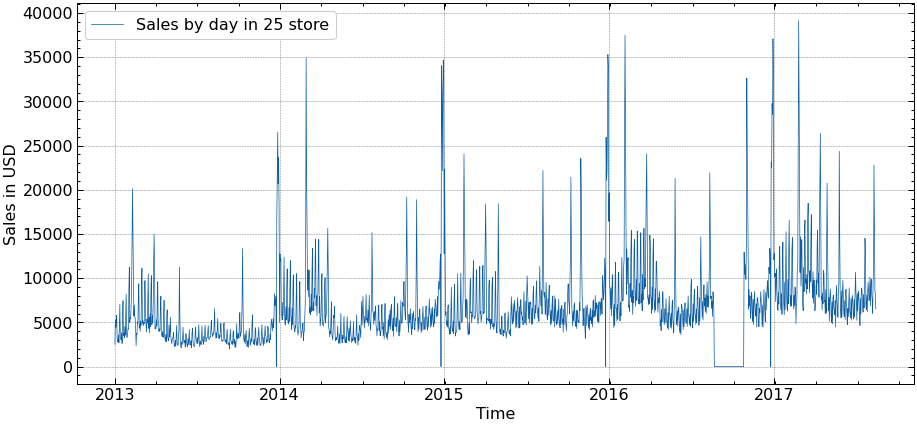

In [15]:
plt.subplots(figsize=(15, 7))
sns.lineplot(data=df_25.asfreq('d', fill_value=0), lw=0.7)
plt.legend(labels=['Sales by day in 25 store'])
plt.xlabel('Time')
plt.ylabel('Sales in USD')
plt.show()

## Задание 3. Сделайте сезонную декомпозицию.

In [16]:
decomposition = seasonal_decompose(df_25, model='additive', period=30)

## Задание 4. Ответы на вопросы.

### Вопрос 1. Сколько элементов содержит исходный датасет?

In [17]:
print(f'В исходном датасете (после группировки и суммирования) {df_25.shape[0]} элементов')

В исходном датасете (после группировки и суммирования) 1618 элементов


### Вопрос 2. Сколько элементов содержит шумовая часть?

In [18]:
print(f'Шумовая часть содержит {decomposition.resid.shape[0]} элементов')

Шумовая часть содержит 1618 элементов


### Вопрос 3. Сколько числовых элементов содержит шумовая часть?

In [21]:
print(f'Шумовая часть содержит {decomposition.resid.notna().sum()} числовых элементов')

Шумовая часть содержит 1588 числовых элементов


### Вопрос 4. Сколько элементов содержит сезонная часть?

In [22]:
print(f'Сезонная часть содержит {decomposition.seasonal.shape[0]} элементов')

Сезонная часть содержит 1618 элементов


### Вопрос 5. Сколько числовых элементов содержит трендовая часть?

In [23]:
print(f'Шумовая часть содержит {decomposition.trend.notna().sum()} числовых элементов')

Шумовая часть содержит 1588 числовых элементов


**Plot of decomposition**

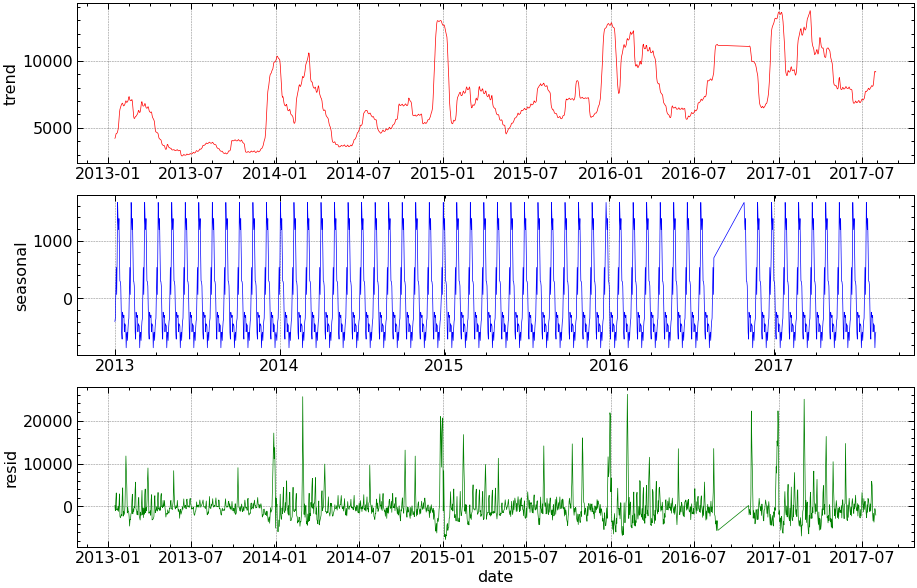

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.lineplot(data=decomposition.trend, ax=ax[0], color='red', lw=0.7).set(xlabel=None)
sns.lineplot(data=decomposition.seasonal, ax=ax[1], color='blue', lw=0.7).set(xlabel=None)
sns.lineplot(data=decomposition.resid, ax=ax[2], color='green', lw=0.7)
plt.show()

## Задание 5. Выполнить тест Дики-Фуллера

In [20]:
fuller_test(df_25.original)

ADF Statistic:  -4.858992703649316
p-value:  4.1883934783888545e-05
Critical Values:
	1%: -3.4344642432857992
	5%: -2.8633571955690647
	10%: -2.5677374399794197
Reject Ho - Time Series is Stationary


# Особенности валидации временных рядов. Практика.

## Задание 1. Разбейте временной ряд, полученный в предыдущем юните, на 3 (train + test) набора.

In [24]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
splits = tscv.split(df_25.original)

## Задание 2. Выведите размеры полученных подвыборок

In [25]:
for train_index, test_index in splits:
    print(f'Train size: {len(train_index)}, Test size: {len(test_index)}')

Train size: 1597, Test size: 7
Train size: 1604, Test size: 7
Train size: 1611, Test size: 7


# Расчет факторов при помощи pandas. Практика.

## Задание 1. Выберите временной ряд для одного магазина (можно из предыдущего задания).

In [82]:
# df_25 - ряз из предыдущего задания

## Задание 2. Постройте скользящее среднее с окном 5.

In [26]:
df_25['SMA5'] = df_25.original.rolling(window=5).apply(np.mean)

## Задание 3. Постройте скользящее квадратичное отклонение среднее с окном 5.

In [27]:
df_25['STD5'] = df_25.original.rolling(window=5).apply(np.std)

## Задание 4. Постройте линии Боллинджера с окном 30.

In [28]:
df_25['SMA30'] = df_25.original.rolling(window=30).apply(np.mean)
df_25['STD30'] = df_25.original.rolling(window=30).apply(np.std)
df_25['BB_HIGH'] = df_25.SMA30 + 3 * df_25.STD30
df_25['BB_LOW'] = df_25.SMA30 - 3 * df_25.STD30

## Задание 5. Отобразите эти оконные факторы на графике.

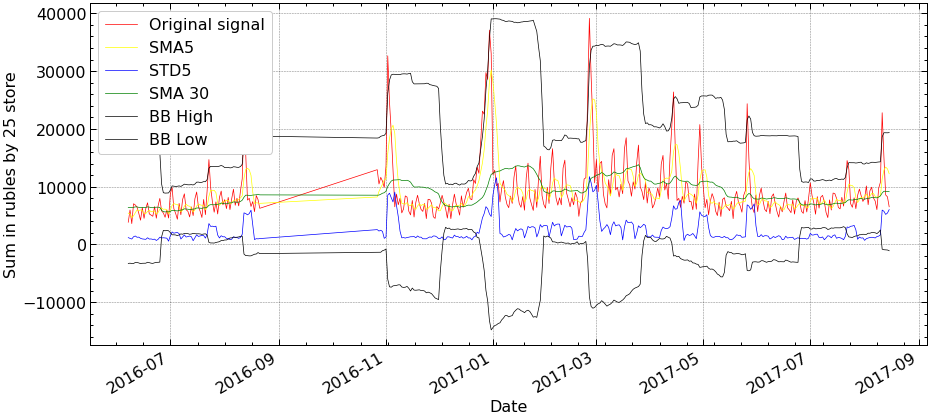

In [29]:
plot_dataframe(
    df_25, 
    1250,
    ['original', 'SMA5', 'STD5', 'SMA30', 'BB_HIGH', 'BB_LOW'],
    ['Original signal', 'SMA5', 'STD5', 'SMA 30', 'BB High', 'BB Low'],
    'Date',
    'Sum in rubles by 25 store',
    ['red', 'yellow', 'blue', 'green', 'black', 'black']
)

# Задание 6. Постройте скользящее среднее с окном 10.

In [30]:
df_25['SMA10'] = df_25.original.rolling(window=10).apply(np.mean)

# Задание 7. Постройте экспоненциально среднее с окном в 7 точек.

In [31]:
df_25['EMA7'] = df_25.original.ewm(min_periods=7, span=7).mean()

# Задание 8. Отобразите их на отдельном графике.

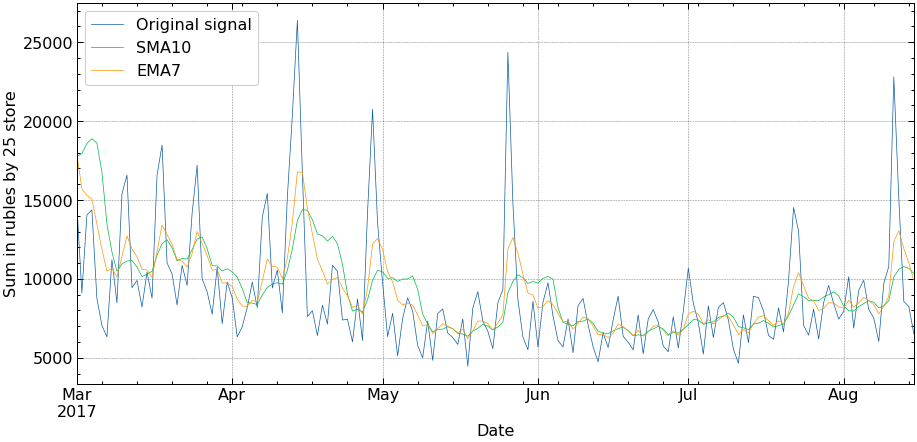

In [35]:
plot_dataframe(
    df_25, 
    1450,
    ['original', 'SMA10', 'EMA7'],
    ['Original signal', 'SMA10', 'EMA7'],
    'Date',
    'Sum in rubles by 25 store'
)

# Задание 9. Напишите свою скользящую функцию, которая будет являться средним арифметическим между максимальным и минимальным заначением unit_sales, используя окно 10.

In [36]:
df_25['rolling_maxmin_10'] = df_25.original.rolling(window=10).apply(lambda x: (max(x) + min(x)) / 2)

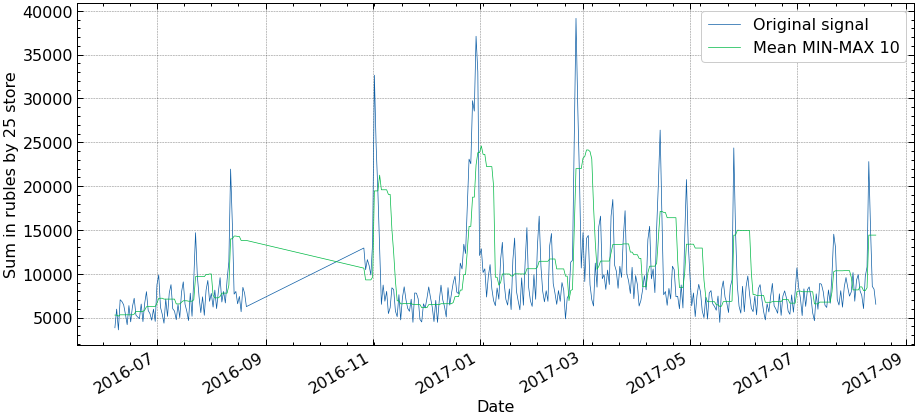

In [38]:
plot_dataframe(
    df_25, 
    1250,
    ['original', 'rolling_maxmin_10'],
    ['Original signal', 'Mean MIN-MAX 10'],
    'Date',
    'Sum in rubles by 25 store'
)

# Задание 10. Постройте скользящее среднее с откном 50 и экспоненциальное скользящее среднее с окном 10. Укажите индексы датафрейма, на которых одно скользящее пересекается с другим.

In [39]:
df_25['SMA50'] = df_25.original.rolling(window=50).apply(np.mean)
df_25['EMA10'] = df_25.original.ewm(min_periods=10, span=10).mean()

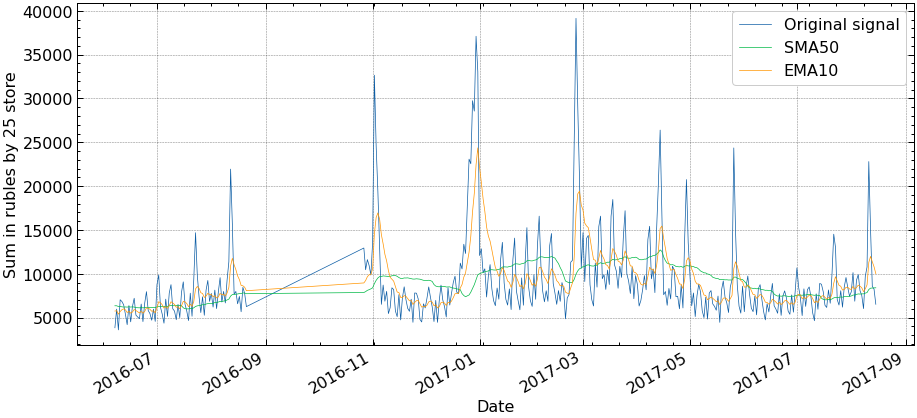

In [40]:
plot_dataframe(
    df_25, 
    1250,
    ['original', 'SMA50', 'EMA10'],
    ['Original signal', 'SMA50', 'EMA10'],
    'Date',
    'Sum in rubles by 25 store'
)

**Let's find out where are crossing of EMA10 and SMA50**

In [41]:
df_25['sign'] = np.sign(df_25['SMA50'] - df_25['EMA10'])

In [42]:
df_25_diff = np.diff(df_25['sign'])

In [43]:
print(*np.where((df_25_diff > 0) | (df_25_diff < 0)))

[  49   51   55   59   62   66   68   73   74   80   81   85   96  142
  146  179  180  185  187  192  237  241  243  273  292  304  305  332
  337  338  378  380  381  421  453  471  472  521  522  534  537  540
  580  611  613  618  628  629  630  632  655  666  673  696  698  702
  703  709  736  771  782  785  787  792  795  799  801  806  808  813
  815  818  829  847  851  882  923  924  937  938  957  960  961 1002
 1019 1029 1039 1078 1101 1126 1136 1140 1144 1148 1150 1155 1156 1174
 1186 1190 1191 1238 1248 1274 1277 1280 1284 1288 1340 1380 1400 1444
 1462 1465 1469 1473 1475 1492 1498 1508 1511 1535 1539 1543 1545 1572
 1574 1585]


# Задание 11. Постройте лаговые факторы с 7-ого по 10-ый и отобразите на графике.

In [44]:
for lag in range(7, 11):
    df_25[f'lag{lag}'] = df_25.original.shift(lag)

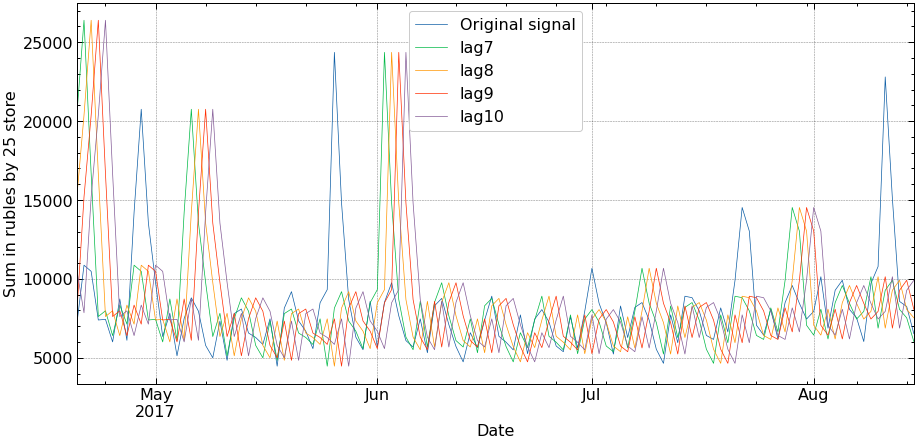

In [45]:
plot_dataframe(
    df_25, 
    1500,
    ['original', 'lag7', 'lag8', 'lag9', 'lag10'],
    ['Original signal', 'lag7', 'lag8', 'lag9', 'lag10'],
    'Date',
    'Sum in rubles by 25 store'
)

# ARIMA/SARIMA. Практика

## Задание 1. Выберите продукт с номером 103501 (item_nbr) и приведите данные к виду временного ряда с группировкой по дате и просуммировать.

In [122]:
# Loading from big CSV file
# df_103501 = load_df('item_nbr', 103501)

In [46]:
# Save to parquet and read
# df_103501.to_parquet('data\\part_1\\item_103501_only.parquet')
df_103501 = pd.read_parquet('data\\part_1\\item_103501_only.parquet')

In [47]:
df_103501 = df_103501.groupby('date')['unit_sales'].sum().reset_index()
df_103501 = df_103501.set_index(pd.DatetimeIndex(df_103501['date']))
df_103501.drop('date', axis=1, inplace=True)
df_103501.rename({'unit_sales': 'original'}, axis=1, inplace=True)

In [48]:
df_103501.sample(5)

,original
date,
2016-10-31,105.0
2013-06-05,103.0
2013-07-07,137.0
2015-08-18,64.0
2017-05-23,114.0


## Задание 2. Выполнить тест Дики-Фуллера. Стационарен ли ряд.

In [49]:
fuller_test(df_103501.values)

ADF Statistic:  -4.15440305801462
p-value:  0.0007863083913836295
Critical Values:
	1%: -3.4344462031760283
	5%: -2.8633492329988335
	10%: -2.5677331999518147
Reject Ho - Time Series is Stationary


## Задание 3. Постройте прогноз методом скользящего среднего с окном 6. Посчитайте метрики MSE, MAE, MAPE.

In [129]:
window_size = 6
ma_forecast = (df_103501.
               rolling(window=window_size).
               mean().
               dropna().
               iloc[: -1].
               set_index(df_103501[window_size:].index)
              )

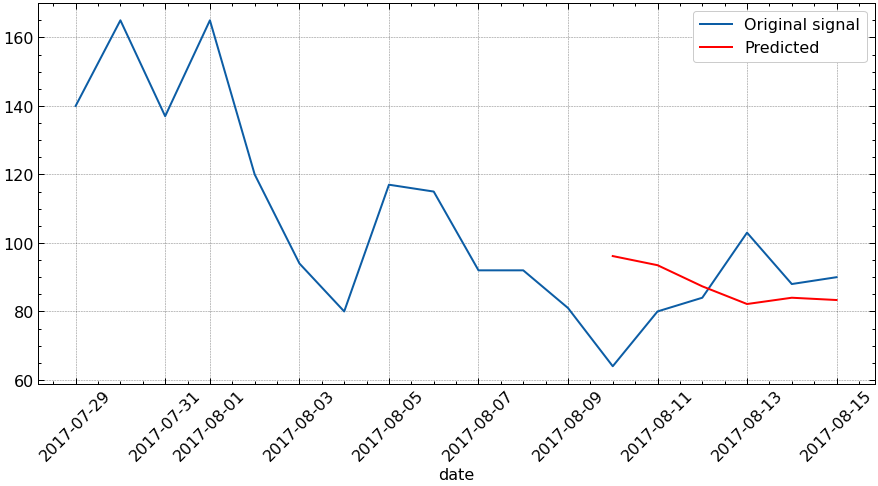

In [132]:
plot_model(df_103501, ma_forecast, window_size)

In [134]:
print_metrics(df_103501, ma_forecast, window_size)

MSE is: 287.087962962963
MAE is: 13.416666666666666
MAPE is: 0.17213844967435177


## Задание 4. Сделайте лаги с 1 по 6.

In [141]:
for lag in range(1, 7):
    df_103501[f'lag_{lag}'] = df_103501.original.shift(lag)
df_103501.dropna(inplace=True)

## Задание 5. Отложите 1-2 последних дня в тестовую выборку для совершения предсказания.

In [142]:
predict_size = 2
x_train, y_train = (
    df_103501[: -predict_size].drop(['original'], axis=1),
    df_103501.original[: -predict_size]
)
x_test, y_test = (
    df_103501[-predict_size:].drop(['original'], axis=1),
    df_103501.original[-predict_size:]
)

## Задание 6. Сделайте прогноз линейной регрессией, Посчитайте метрики MSE, MAE, MAPE.

In [143]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = pd.Series(model.predict(x_test), index=x_test.index)

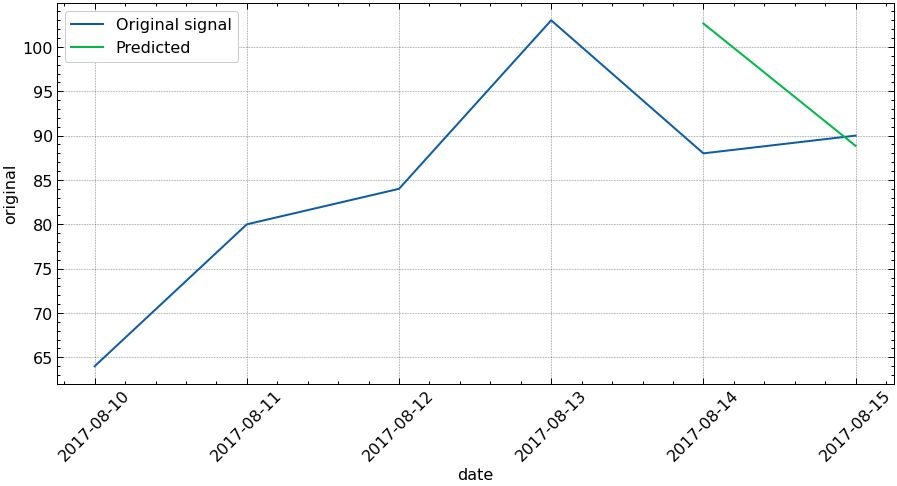

In [145]:
plot_model(df_103501.original, y_pred, predict_size)

In [147]:
print_metrics(y_test, y_pred, predict_size)

MSE is: 107.89044952392578
MAE is: 7.898700714111328
MAPE is: 0.08961234241724014


## Задание 7. Определите p и q.

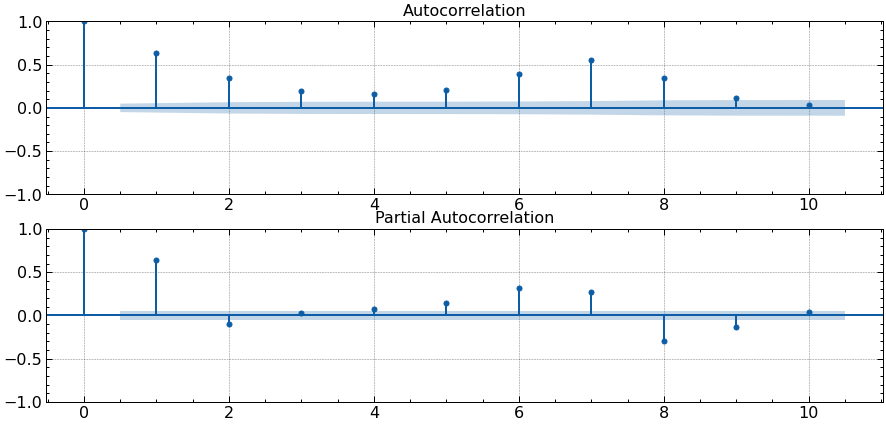

In [150]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_103501.original.values.squeeze(), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_103501.original.values.squeeze(), lags=10, method='ywm', ax=ax2)

**Checking best params for ARIMA**

In [151]:
import warnings
warnings.filterwarnings('ignore')

p = range(0, 7)
d = range(0, 1)
q = range(0, 7)
pdq = list(itertools.product(p, d, q))
best_pdq = (0, 0, 0)
best_aic = np.inf
for params in pdq:
    model_test = ARIMA(y_train.values.reshape(-1), order=params)
    result_test = model_test.fit()
    if result_test.aic < best_aic:
        best_pdq = params
        best_aic = result_test.aic
print(best_pdq, best_aic)

(6, 0, 4) 14753.695573201632


**Determinate p, d, q**  
p = 6
d = 0
q = 4

## Задание 8. Постройте ARIMA, сравните метрики.

In [152]:
arima_model = ARIMA(y_train.values.reshape(-1), order=best_pdq)

In [153]:
train_size = len(y_train)
test_size = predict_size
arima_model = arima_model.fit()
arima_predict = arima_model.predict(start=train_size, end=train_size+test_size-1, dynamic=False)

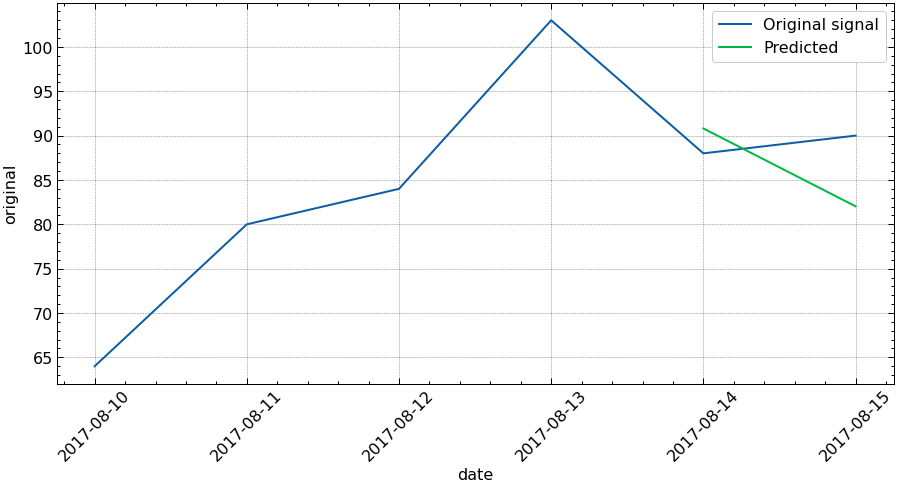

In [162]:
plot_model(df_103501.original, pd.Series(arima_predict, index=x_test.index), predict_size)

In [405]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1617
Model:                 ARIMA(6, 0, 4)   Log Likelihood               -7364.848
Date:                Tue, 14 Feb 2023   AIC                          14753.696
Time:                        13:26:23   BIC                          14818.356
Sample:                             0   HQIC                         14777.693
                               - 1617                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.2056      3.143     32.203      0.000      95.046     107.365
ar.L1          1.2928      0.035     36.571      0.000       1.223       1.362
ar.L2         -1.5370      0.058    -26.663      0.000      -1.650      -1.424
ar.L3          1.2511      0.073     17.226      0.000       1.109       1.393
ar.L4         -0.9320      0.070    -13.373      0.000      -1.069      -0.795
ar.L5          0.2396      0.054      4.436      0.000       0.134       0.345
ar.L6          0.2966      0.031      9.694      0.000       0.237       0.357
ma.L1         -0.7394      0.025    -29.404      0.000      -0.789      -0.690
ma.L2          1.2973      0.028     45.773      0.000       1.242       1.353
ma.L3         -0.6896      0.027    -25.603      0.000      -0.742      -0.637
ma.L4          0.7967      0.020     39.050      0.000       0.757       0.837
sigma2       605.6356     18.836     32.154      0.000     568.718     642.553
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               471.67
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.73
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [164]:
print_metrics(y_test, pd.Series(arima_predict, index=x_test.index), predict_size)

MSE is: 35.70555832331122
MAE is: 5.388824248870378
MAPE is: 0.06023023647490826


## Задание 9. Выводы.

**MA metrics**  
MSE is: 287.087962962963  
MAE is: 13.416666666666666  
MAPE is: 0.17213844967435177  

**LR metrics**  
MSE is: 107.89044952392578  
MAE is: 7.898700714111328  
MAPE is: 0.08961234241724014  

**ARIMA metrics**  
MSE is: 35.70555832331122  
MAE is: 5.388824248870378  
MAPE is: 0.06023023647490826  

Итак, самая простая модель MA дала самаю высокую ошибку. Линейная регрессия без подбора параметров значительно улучшила результат. 
ARIMA же ещё больше улучшила прогноз. 